# Initialization

In [1]:
# %load init.ipy
import os, sys, logging, datetime
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import corner
import tqdm
import memory_profiler as mpro

import kalepy as kale
from kalepy.utils import plot_control, nbshow
from kalepy import _PATH_NB_OUT

# NOTE: This is for when the notebook is converted to a python script
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))

%reload_ext autoreload
%autoreload 2


In [2]:
def fig_fname(fname):
    fname = "nb__kernels__" + fname
    fname = os.path.join(_PATH_NB_OUT, fname)
    kale.utils.check_path(fname)
    return fname

# Distributions

Gaussian
SUCCESS:: PDF is unitary
SUCCESS:: PDF is non-zero over support
Box_Asym
SUCCESS:: PDF is unitary
SUCCESS:: PDF does have finite support
SUCCESS:: PDF is non-zero over support
Parabola
SUCCESS:: PDF is unitary
SUCCESS:: PDF does have finite support
SUCCESS:: PDF is non-zero over support


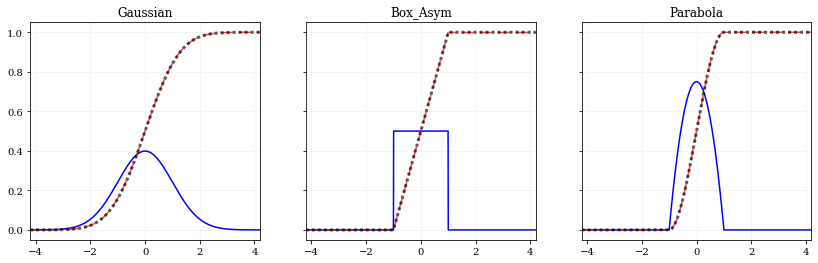

In [3]:
def test_distribs(plot=None):
    distribs = kale.kernels.get_all_distribution_classes()
    num = len(distribs)
    xe, xc, dx = kale.utils.bins(-5.0, 5.0, 3000)

    if plot is None:
        plot = kale.utils._is_notebook()

    fname = fig_fname("test_distribs.pdf")
    with kale.utils.plot_control(fname):
        
        fig, axes = plt.subplots(figsize=[14, 4], ncols=num, sharey=True, sharex=True)
        for ax in axes:
            ax.grid(alpha=0.15)

        ax.set_xlim([-4.2, 4.2])

        for ax, dist in zip(axes, distribs):
            dist = dist()
            name = dist.name()
            print(name)
            ax.set_title(name)  # .__class__.__name__)
            pdf = dist.evaluate(xc)
            tot = np.trapz(pdf, x=xc)
            l1, = ax.plot(xc, pdf, 'b-')

            ax.plot(xc, np.cumsum(pdf*dx), 'r', ls=(0, [8, 4]), alpha=0.75)
            ax.plot(xc, dist.cdf(xc), 'k', ls=(0, [1, 1]), lw=3.0, alpha=0.65)

            # Make sure that the total probability is near unity
            kale.utils.allclose(tot, 1.0, rtol=1e-2, msg="PDF is {fail:}unitary")
            # Make sure distributions have the right support
            if dist.FINITE:
                outside = (xc < -1.0) | (1.0 < xc)
                inside = (-1.0 < xc) & (xc < 1.0)
                kale.utils.allclose(pdf[outside], 0.0, atol=1e-6, msg="PDF does {fail:}have finite support")
            else:
                inside = slice(None)

            kale.utils.alltrue(pdf[inside] > 0.0, msg="PDF is {fail:}non-zero over support")
        
    return

test_distribs()

## Check CDF & PPF

yerr =  [1.58e-16, 0.00e+00, 1.60e-16 ... 0.00e+00, 0.00e+00, 1.73e-16]
zerr =  [3.17e-16, 0.00e+00, 0.00e+00 ... 1.52e-16, 0.00e+00, 5.20e-16]


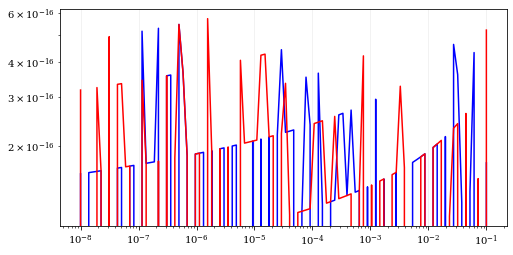

In [4]:
def test_cdf_ppf():
    
    fname = fig_fname("test_cdf_ppf.pdf")
    with kale.utils.plot_control(fname):

        dist = kale.Gaussian()

        tol = np.logspace(-8, -1, 100)

        y1 = dist.ppf(tol)
        y2 = sp.stats.norm.ppf(tol)

        z1 = dist.ppf(1 - tol)
        z2 = sp.stats.norm.ppf(1 - tol)

        yerr = np.fabs((y2 - y1) / np.minimum(y1, y2))
        print("yerr = ", kale.utils.array_str(yerr))

        zerr = np.fabs((z2 - z1) / np.minimum(z1, z2))
        print("zerr = ", kale.utils.array_str(zerr))

        fig, ax = plt.subplots(figsize=[8, 4])
        ax.grid(alpha=0.2)
        ax.set(xscale='log', yscale='log')

        ax.plot(tol, yerr, 'b-')
        ax.plot(tol, zerr, 'r-')

    return

test_cdf_ppf()

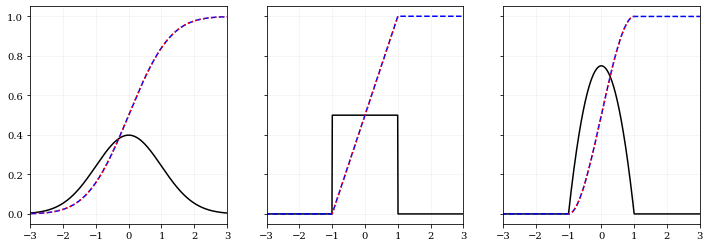

In [5]:
distribs = kale.kernels.get_all_distribution_classes()
NUM = int(1e4)

num_dist = len(distribs)
fig, axes = plt.subplots(figsize=[4*num_dist, 4], ncols=num_dist, sharey=True, sharex=True)
for ax in axes:
    ax.grid(alpha=0.15)
    ax.set_xlim([-3, 3])

xx = np.linspace(-5, 5, 1000)

for ii, (ax, dist) in enumerate(zip(axes, distribs)):
    dist = dist()
    pdf = dist.evaluate(xx)
    ll, = ax.plot(xx, pdf, 'k-')
    cdf = np.cumsum(kale.utils.trapz_dens_to_mass(pdf, xx))
    cdf = np.append([0.0], cdf)
    ax.plot(xx, cdf, 'b--')
    
    kale.utils.allclose(cdf, dist.cdf(xx), rtol=1e-3, atol=1e-3)
    
    yy = np.linspace(0.0, 1.0, 1000)
    zz = dist.ppf(yy)
    ax.plot(zz, yy, 'r:')
    
    pad = 1e-4
    idx = ((cdf > pad) & (cdf < 1.0 - pad))
    kale.utils.allclose(xx[idx], dist.ppf(cdf[idx]), rtol=1e-3, atol=1e-3)
    

## Check Support and Unitarity

Gaussian
tot = 1.0000e+00
SUCCESS:: PDF is  unitary
SUCCESS:: samples are within support
Box_Asym
tot = 1.0003e+00
SUCCESS:: PDF is  unitary
SUCCESS:: samples are within support
Parabola
tot = 1.0000e+00
SUCCESS:: PDF is  unitary
SUCCESS:: samples are within support


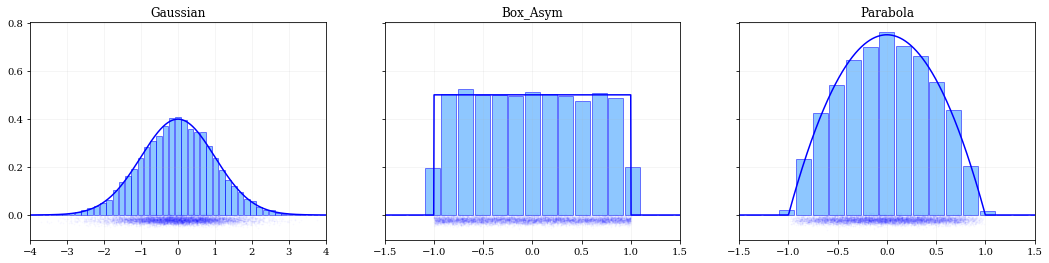

In [6]:
distribs = kale.kernels.get_all_distribution_classes()
NUM = int(1e4)

num_dist = len(distribs)
fig, axes = plt.subplots(figsize=[6*num_dist, 4], ncols=num_dist, sharey=True, sharex=False)
for ax in axes:
    ax.grid(alpha=0.15)
    ax.set_xlim([-4, 4])

xe, xc, dx = kale.utils.bins(-5.0, 5.0, 60)
# ax.set_xlim([-4.2, 4.2])

fine = kale.utils.spacing(xe, 'lin', 3000)

for ax, dist in zip(axes, distribs):
    dist = dist()
    name = dist.name()
    xlim = [-1.5, 1.5] if dist.FINITE else [-4.0, 4.0]
    ax.set_xlim(xlim)

    print(name)
    ax.set_title(name)
    pdf = dist.evaluate(fine)
    l1, = ax.plot(fine, pdf, 'b-')
    tot = np.trapz(pdf, x=fine)
    print("tot = {:.4e}".format(tot))
    kale.utils.allclose(tot, 1.0, rtol=1e-3, msg="PDF is {fail:} unitary")

    samp = dist.sample(NUM)
    ax.hist(samp, bins=xe, density=True, edgecolor='b', facecolor='dodgerblue', alpha=0.5, rwidth=0.9)
    xvals = samp
    yvals = np.random.normal(-0.02, 0.01, xvals.size)
    ax.scatter(xvals, yvals, marker='.', s=2, alpha=0.02, color='b')

    # Make sure samples are in the right regions
    if dist.FINITE:
        # outside = ( < -1.0) | (1.0 < xc)
        inside = (-1.0 <= xvals) & (xvals <= 1.0)
    else:
        inside = np.ones_like(xvals, dtype=bool)

    kale.utils.alltrue(inside, msg="samples are {fail:}within support")

    
plt.show()


==== Gaussian ====
SUCCESS:: PDF is unitary
SUCCESS:: PDF is non-zero over support

==== Box_Asym ====


/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: No contour levels were found within the data range.
/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: No contour levels were found within the data range.


SUCCESS:: PDF is unitary
SUCCESS:: PDF does have finite support
SUCCESS:: PDF is non-zero over support

==== Parabola ====
SUCCESS:: PDF is unitary
SUCCESS:: PDF does have finite support
SUCCESS:: PDF is non-zero over support


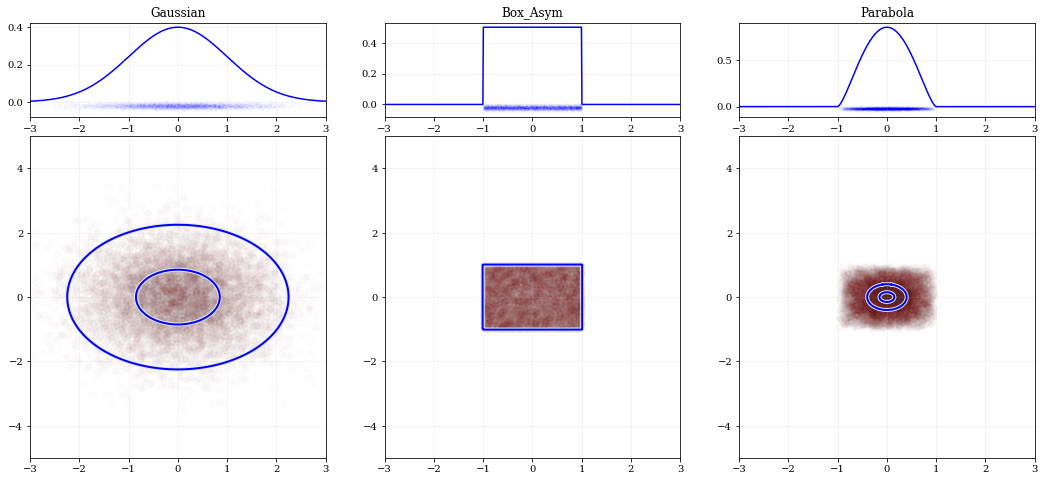

In [7]:
distribs = kale.kernels.get_all_distribution_classes()

# distribs = [kale.kernels.get_distribution_class('triweight')]

NUM = int(1e5)
LEV = 4
bin_extr = [-5, 5]
ax_extr = [-3, 3]

num_dists = len(distribs)

# Setup Figure / Axes
# --------------------------------------
gs = mpl.gridspec.GridSpec(4, num_dists)
fig = plt.figure(figsize=[6*num_dists, 8])
axes = np.empty((2, num_dists), dtype=object)
for ii, jj in np.ndindex(axes.shape):
    xx = slice(0, 1, None) if ii == 0 else slice(1, 4, None)
    prev = axes[0, jj] if ii > 0 else None
    axes[ii, jj] = plt.subplot(gs[xx, jj], sharex=prev)
    axes[ii, jj].grid(alpha=0.15)
    
# Setup Grids / Bins
# -------------------------------
xe, xc, dx = kale.utils.bins(*bin_extr, 1000)
ye, yc, dy = kale.utils.bins(*bin_extr, 1000)

edges = [xe, ye]
# areas = dx[:, np.newaxis] * dy[np.newaxis, :]
percs = sp.stats.norm.cdf([1.0, 2.0])
xg, yg = np.meshgrid(xc, yc, indexing='ij')
grid = [xg.flatten(), yg.flatten()]

# Iterate over distributions and test
# -------------------------------------------------
for axcol, dist in zip(axes.T, distribs):
    dist = dist()
    name = dist.name()
    print("\n==== {} ====".format(name))
    # if not name.lower().startswith('tri'): continue
    
    pdf_e = dist.grid([xe, ye])
    pdf_c = dist.grid([xc, yc])

    pdf_e_xproj = np.trapz(pdf_e, x=ye, axis=-1)
    pdf_e_yproj = np.trapz(pdf_e, x=xe, axis=0)
    # print(np.trapz(pdf_e_xproj, x=xe))
    # print(np.trapz(pdf_e_yproj, x=ye))
    
    pmf = kale.utils.trapz_dens_to_mass(pdf_e, edges)
    samp = dist.sample(NUM//10, 2)
    
    ax = axcol[0]
    ax.set_title(name)
    
    ax.plot(xe, pdf_e_xproj, 'b-')
    xvals = samp[0]
    yvals = np.random.normal(-0.02, 0.01, xvals.size)
    ax.scatter(xvals, yvals, marker='.', s=2, alpha=0.01, color='b')
    
    ax = axcol[1]
    vals = pmf
    levels = np.unique(np.percentile(vals[vals > 0], 100*np.atleast_1d(percs)))

    ax.contour(xg, yg, vals.T, levels=levels, zorder=10, linewidths=4.0, colors='0.9', alpha=1.0)
    ax.contour(xg, yg, vals.T, levels=levels, zorder=11, linewidths=2.0, colors='blue')

    ax.scatter(*samp, facecolor='firebrick', edgecolor='0.25', alpha=0.01)
    
    ax.set(xlim=ax_extr)
    
    # Tests
    # -------------
    # Make sure that the total probability is near unity
    tot = np.sum(pmf)
    # print("tot = ", tot) # , kale.utils.stats_str(tot), kale.utils.array_str(tot))
    kale.utils.allclose(tot, 1.0, rtol=1e-2, msg="PDF is {fail:}unitary")
    # Make sure distributions have the right support
    if dist.FINITE:
        inside = dist.inside(grid).reshape(xg.shape)
        outside = ~inside
        kale.utils.allclose(pdf_c[outside], 0.0, atol=1e-6, msg="PDF does {fail:}have finite support")
    else:
        inside = slice(None)

    kale.utils.alltrue(pdf_c[inside] > 0.0, msg="PDF is {fail:}non-zero over support")
    
    
plt.show()

## Covariance

In [8]:
# NUM = int(1e5)
# np.random.seed(9876)


# sigma = [1.5, 1.5]
# corr = 0.7

# s2 = np.square(sigma)
# cc = corr*sigma[0]*sigma[1]
# cov = [[s2[0], cc], [cc, s2[1]]]

# cov = np.array(cov)
# print(cov, "\n")

# distribs = kale.get_all_distribution_classes()
# # print(kernels)
# fig, axes = plt.subplots(figsize=[15, 5], ncols=len(distribs), nrows=2)


# for (ii, jj), ax in np.ndenumerate(axes):
# #     kern = kernels[jj]
#     kern = kale.kernels.Kernel(distribution=distribs[jj])
#     print(kern.distribution.__class__.__name__)

#     if ii == 0:
#         edges = [np.linspace(-2*ss, 2*ss, 100) for ss in sigma]
#         pdf = kern.grid(edges, bw=sigma[0])
#         ax.contour(*edges, pdf)
        
#     else:  
#         data = kern.sample(2, cov, NUM)
#         data_cov = np.cov(*data)
#         print("\n", ii, kern)
#         print(data_cov)

#         ax.scatter(*data, alpha=0.02)
#         ax.axis('equal')
#         ax.grid(alpha=0.2)
#         ax.set_title(kern.__name__)

#         assert np.allclose(data_cov, cov, rtol=1e-2), "Data covariance does not match input!"

    
# plt.show()

## Resampling

In [9]:
# def resample_at_kernel_bandwidth(ax, kern, bw):
#     NUM = int(1e5)
#     xe, xc, dx = kale.utils.bins(-2*bw, 2*bw, 40)
#     samp = kern.sample(1, bw, NUM).squeeze()
    
#     hist, _ = np.histogram(samp, xe, density=True)
#     pdf = kern.evaluate(xc, 0.0, bw)

#     hist_cum = np.cumsum(hist*dx)
#     hist_cum = np.append([0.0], hist_cum)
#     cdf = kern.cdf(xe, bw=bw)
    
#     ax.hist(samp, xe, histtype='step', color='b', density=True)
#     ax.plot(xc, pdf, color='b', ls='--')
    
#     ax.plot(xe, hist_cum, color='r', ls='-')
#     ax.plot(xe, cdf, color='r', ls='--')
    
#     for aa, bb, name in zip([hist, hist_cum], [pdf, cdf], ['pdf', 'cdf']):
#         idx = (aa > 0.0) & (bb > 0.0)
#         dof = np.count_nonzero(idx) - 1
#         x2 = np.sum(np.square(aa[idx] - bb[idx])/bb[idx]**2)
#         x2 = x2 / dof        
#         print("Kernel: {}, bw: {:.2e} :: {} : x2/dof = {:.4e}".format(kern.__name__, bw, name, x2))
#         print("\t" + kale.utils.array_str(aa[idx]))
#         print("\t" + kale.utils.array_str(bb[idx]))
#         tools.assert_true(x2 < 1e-2)
        
#     return


# bandwidths = [0.5, 2.0]  #, 2.0]
# colors = ['r', 'b']  # , 'g']

# # kernels = kale.get_all_distribution_classes()
# kernels = []
# fig, axes = plt.subplots(figsize=[14, 6], ncols=len(kernels), nrows=len(bandwidths))
    
# for (ii, jj), ax in np.ndenumerate(axes):
#     kern = kernels[ii]
#     bw = bandwidths[jj]
#     resample_at_kernel_bandwidth(ax, kern, bw)

# plt.show()

# Particular Kernels

## Box / Puck

In [10]:
# size = int(1e3)
# ndim = 1

# fig, axes = plt.subplots(figsize=[12, 4], ncols=3, sharex=True, sharey=True)
# for ax in axes:
#     ax.grid(alpha=0.15)  

# def plot(ax, ss, title):  
#     ax.set_title(title)
#     xvals = ss.squeeze()
#     yvals = np.random.uniform(-0.03, 0.01, xvals.size)
#     ax.scatter(xvals, yvals, marker='.', s=2, alpha=0.1)
#     ax.hist(xvals, density=True, rwidth=0.8, alpha=0.8, edgecolor='k')    
#     return
    
# # Draw samples from distribution
# samps = np.random.uniform(-1.0, 1.0, size=ndim*size).reshape(ndim, size)
# print(kale.utils.minmax(samps))

# plot(axes[0], samps, "Uniform Distribution")
    
    
# # Remove covariance
# samp_cov = np.cov(*samps)
# samps = kale.utils.rem_cov(samps, samp_cov)
# print(kale.utils.minmax(samps))

# plot(axes[1], samps, "Removed Covariance")


# # Rescale Distribution
# samps = samps * np.sqrt(1/3)
# print(kale.utils.minmax(samps))

# plot(axes[2], samps, "Rescaled Distribution")


# plt.show()

In [11]:
# size = int(1e5)
# ndim = 2

# fig, axes = plt.subplots(figsize=[12, 4], ncols=3, sharex=True, sharey=True)
# for ax in axes:
#     ax.grid(alpha=0.15)  

# def plot(ax, ss, title):  
#     ax.set_title(title)
#     ax.scatter(*ss, marker='.', s=2, alpha=0.1)
#     # ax.hist(xvals, density=True, rwidth=0.8, alpha=0.8, edgecolor='k')    
#     return
    
# # Draw samples from distribution
# samps = np.random.uniform(-1.0, 1.0, size=ndim*size).reshape(ndim, size)
# print(kale.utils.minmax(samps))

# plot(axes[0], samps, "Uniform Distribution")
    
    
# # Remove covariance
# samp_cov = np.cov(*samps)
# print("cov = ", samp_cov)
# samps = kale.utils.rem_cov(samps, samp_cov)
# print("cov = ", np.cov(*samps))
# print(kale.utils.minmax(samps))

# plot(axes[1], samps, "Removed Covariance")


# # Rescale Distribution
# samps = samps * np.sqrt(1/3)
# print(kale.utils.minmax(samps))

# plot(axes[2], samps, "Rescaled Distribution")


# plt.show()

## Epanechnikov (Parabola)

### Show that the median method is the same as CDF inversion 

In [12]:
# def draw_invert(size):
#     xe, xc, dx = kale.utils.bins(-1.0, 1.0, 1000)
#     yy = kale.kernels.Parabola.evaluate(xc)
#     cs = np.cumsum(yy*dx)
    
#     xc = np.concatenate([[-1.0], xc, [1.0]])
#     cs = np.concatenate([[0.0], cs, [1.0]])
    
#     xx = sp.interpolate.interp1d(cs, xc, kind='cubic')(np.random.uniform(0.0, 1.0, size))
#     return xx

# def draw_median(size):
#     xx = np.random.uniform(-1, 1, 3*size).reshape(3, size)
#     xx = np.median(xx, axis=0)
#     return xx
    

In [13]:
# NUM = int(1e4)

# aa = draw_median(NUM)
# edges, cents, wids = kale.utils.bins(-1.1, 1.1, 40)

# hist, _ = np.histogram(aa, edges, density=True)
# cum_hist = np.cumsum(hist*wids)
# pdf = kale.kernels.Parabola_Asym.evaluate(cents)
# cum_pdf = np.cumsum(pdf*wids)

# test = draw_median(NUM)
# hist_test, _ = np.histogram(test, edges, density=True)
# cum_test = np.cumsum(hist_test*wids)

# plt.plot(cents, hist, 'r-')
# plt.plot(cents, cum_hist, 'r--')

# plt.plot(cents, hist_test, 'g-')
# plt.plot(cents, cum_test, 'g--')

# plt.plot(cents, pdf, 'b-')
# plt.plot(cents, cum_pdf, 'b--')